In [ ]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.linalg

# System Identification

This notebook will guide you through the process of system identification for linear discrete-time systems by way of numerical examples. Throughout, we will assume that the underlying system dynamics are not changing with time. This is sometimes called "time-invariance" in the literature, but that particular phrasing is not important here.

# 1. Introduction

We have a discrete-time system with some input $\vec{u}[i]\in\mathcal{R}^{p}$ and a state $\vec{x}[i]\in\mathcal{R}^{n}$. At timestep $i+1$, the value of state $\vec{x}$ evolves by

$$\vec{x}[i+1] = A\vec{x}[i] + B\vec{u}[i]$$

where $A\in\mathcal{R}^{n\times n}$ is the *state transition matrix* and $B\in\mathcal{R}^{n\times p}$ is the *input matrix*. The system $(A, B)$ could represent any kind of physical system whose behavior we want to modify. You've seen how the behavior of an electrical circuit can be described in the form $\vec{x}[i+1] = A\vec{x}[i] + B\vec{u}[i]$ if we choose a time interval $\Delta$ and sample the appropriate states (voltages on capacitors and currents through inductors). It turns out that a lot of physical systems can be described this way-- electrical systems, mechanical systems, robotic systems, and even biological systems, to name a few. The really great thing about control theory is that it works for all of these.

For a given physical system, how do we find $A$ and $B$? This is called *finding a model* for the system, or the *modeling problem* in general. If we know a lot about our system, we can sometimes find it directly. For example, if you want to find a model for an electrical circuit, and you know all the component values, you can use circuit analysis to solve for $A$ and $B$. But a lot of the time, we can't do this! the system may too complicated: for example, a hyper-realistic model of car dynamics is critical for controlling an autonomous vehicle, but it would be too difficult to work the model out directly from classical mechanics. Or perhaps the information is hidden: in a biological system, you may not know exactly what biological processes are going on. How do we solve the modeling problem if our system can't be analyzed directly?

Well, if we have access to the system, we can always run some experiments and hypothesize some $A$ and $B$. Suppose we took some sequence of known inputs $\vec{u}[i]$, fed it into the system, and observed the sequence of $\vec{x}[i]$ that came out. If we assume that our data follows $\vec{x}[i+1] = A\vec{x}[i] + B\vec{u}[i]$ for some $A$ and $B$, we can use our data to figure out what they are. You could think of this as the scientific method, or as statistics, or as the prototypical kind of machine learning-- but in control theory lingo, it's known as *system identification*. In a way, this is the OG of machine learning. 

# 2. How to Identify Your System.

Perhaps it makes sense that we can use data gathered from a system to identify an $A$ and $B$ matrix, but how is it actually done?

Well, let's suppose we have data from an experiment that we ran, which started at time $0$ and ended at time $k$. In other words, we have state data
$$ x[0], x[1],\dotsc,x[k],$$
and input data
$$ u[0], u[1], \dotsc, u[k-1]. $$
Such a data set is called a *trace*.

We are also hypothesizing, of course, that the state and input data are related by
$$ x[i+1] = A x[i] + B u[i]. $$
If our hypothesis is true, we expect our data to satisfy the equations
\begin{align}
x[1] &= A x[0] + B u[0]\\
x[2] &= A x[1] + B u[1]\\
x[3] &= A x[2] + B u[2]\\
 &\vdots\\
x[k] &= A x[k-1] + B u[k-1].
\end{align}
As you can see, we have $k$ equations in $n^2+np$ variables (the variables being the elements of $A$ and $B$). All we have to do is solve this system of equations, and we will have what we wanted! Typically, we will have many more observations than variables (i.e. $k > n^2+np$), so we will have to solve the system using *least squares*.

The first step to solving the system is to write it in matrix form. The code we have provided will give you the state and input data in the form of the following matrices:
\begin{align}
U &= \begin{bmatrix} u[0]^T \\ u[1]^T \\ \vdots \\ u[k-1]^T \end{bmatrix}, &
X &= \begin{bmatrix} x[0]^T \\ u[1]^T \\ \vdots \\ x[k]^T \end{bmatrix}
\end{align}

so it would be convenient to write the matrix equation so that the data shows up in roughly that form. Doing that, we get the matrix equation
$$
\begin{bmatrix}
x[0]^T & u[0]^T\\ 
x[1]^T & u[1]^T\\ 
\vdots & \vdots\\
x[k-1]^T & u[k-1]^T
\end{bmatrix}
\begin{bmatrix}
A^T \\ B^T
\end{bmatrix}
=
\begin{bmatrix} 
x[1]^T\\ 
x[2]^T\\ 
\vdots\\ 
x[k]^T
\end{bmatrix},
$$
Which we can then solve using standard least-squares methods.

## Example 1: Identifying a System We Already Know

Let's start with a simple example to show yout how it works.
What we'll do is create a system whose $A$ and $B$ matrices are known, so that we know if we're right when we identify the system later. To keep things simple, we'll choose a second-order system. It may have come from an RLC circuit, or a robotic system, or something else; for our purposes, it doesn't make any difference. Specifically, we'll use
\begin{align}
A &= \begin{bmatrix} 0 & 1 \\ 0.3 & 0.2 \end{bmatrix}, & B &= \begin{bmatrix} 0 \\ 1 \end{bmatrix}.
\end{align}
Like I said, this is a simple case. We have a system with $n=2$ states and $p=1$ input.

Now, let's set these up in NumPy.

In [ ]:
a_known = np.matrix([[0, 1],
                     [0.3, 0.2]])
b_known = np.matrix([[0],
                     [1]])

Next, we need to collect some data from this system. We'll use the following function to do this for us. Try following along with the code, and be sure to read the documentation.

In [ ]:
def make_state_trace(a_matrix, b_matrix, inpt, initial_state=None):
    """
    make_state_trace: for a given A and B matrices, initial condition, and input, "run" the system and 
    calculate the system state for each time step. The length of the trace will be the length of the input plus one.
    
    arguments:
        a_matrix: A matrix of the system (numpy matrix, n by n)
        b_matrix: B matrix of the system (numpy matrix, p by n)
        inpt: input (u) (numpy matrix, T by p)
              initial_state: initial state for the system (numpy matrix, n by 1). If no initial state is provided, 
              the initial state will be the origin.
    
    returns:
        state_trace: a numpy matrix/ndarray containing the state at 
                     each time step that was run (numpy ndarray, T+1 by n).
    """
    n_states = np.shape(a_matrix)[0]
    n_timesteps = np.shape(inpt)[0]
    state_trace = np.zeros((n_timesteps+1, n_states))
    if initial_state:
        x0 = initial_state
    else:
        x0 = np.matrix(np.zeros((n_states, 1)))
    state_trace[0,:] = np.array(x0.T)
    for i in range(n_timesteps):
        current_state = np.matrix(state_trace[i,:]).T
        current_inpt = np.matrix(inpt[i]).T
        next_state = a_matrix*current_state + b_matrix*current_inpt
        state_trace[i+1,:] = np.array(next_state.T)
    return state_trace

Now, let's choose an input to feed into the system, and get a state trace from it.

What kind of signal should we use as an input? In principle, it can be anything we want-- but some choices are better than others. One kind of input that generally works quite well is a *random input*, that is where each $u[i]$ is chosen at random. In this notebook, we'll be using random inputs to excite our systems. In particular, we will use a Gaussian distribution which you have or will see in CS 70.

In [ ]:
def random_input(t, n_inputs, mean=0, std=1):
    """
    random_input: given a time sequence t, generate a random input trace. Each entry of the trace will be sampled
                  from a Gaussian distribution with the given mean and standard deviation.
    """
    k = np.shape(t)[0]
    random_trace = np.random.normal(loc=mean, scale=std, size=(k, n_inputs))
    random_trace = np.matrix(random_trace)
    return random_trace

In [ ]:
k = 6
t = t = np.arange(k)

u_trace = random_input(t, 1)
# How did I know to make u1 into a NumPy matrix with dimensions (k,1)? Well, the documentation of make_state_trace 
# says that's how it needs the input trace argument to be.

x_trace = make_state_trace(a_known, b_known, u_trace)

# Let's see what the state trace looks like.
plt.plot(t, u_trace, label='input')
plt.plot(t, x_trace[:-1,0], label='state 1')
plt.plot(t, x_trace[:-1,1], label='state 2')
plt.legend(loc='best')

Now that we have a trace from our known system, let's use least squares to identify $A$ and $B$, and see if we get what we expect.

In [ ]:
def identify_system(state_trace, inpt):
    """
    identify_system: given an input and the state trace it generated, determine the A and B matrices 
                     of the system that was used to generate the state trace.
    
    arguments:
        state_trace: the state data.
        inpt: the input data:
        
    returns:
        a_identified: the A matrix identified from the state and input data (numpy matrix)
        b_identified: the B matrix identified from the state and input data (numpy matrix)
    """

    # set up least-squares equation from state and input data
    n_states = np.shape(state_trace)[1]
    n_inputs = np.shape(inpt)[1]
    lsq_b = np.matrix(state_trace[1:,:])
    lsq_a = np.concatenate((state_trace[:-1,:],inpt),axis=1)
    # solve the least-squares problem. Output should be [A B]^T
    # Based on the code around it, it looks like your code needs to produce two variables called a_identified
    # and b_identified.
    ab_identified, residuals, rank, s = np.linalg.lstsq(lsq_a, lsq_b, rcond=None)
    # What else does your code need to do? Well, let's look at the documentation. You need to return two variables,
    # a_identified and b_identified, and they both need to be numpy matrices.
    a_identified = ab_identified[:n_states,:]
    a_identified = np.matrix(a_identified).T
    b_identified = ab_identified[n_states:,:]
    b_identified = np.matrix(b_identified).T
    
    return a_identified, b_identified


Now, let's see if the system identification function works with the code you put in. Fingers crossed!

In [ ]:
a_identified, b_identified = identify_system(x_trace, u_trace)
print('identified A matrix:')
print(a_identified)
print('identified B matrix:')
print(b_identified)

If you got the code right, the previous cell should have printed out an $A$ and $B$ matrix that are very close to the known $A$ and $B$. It's okay if they're a tiny amount off, for example if an element that we know is 0 was identified as 1e-16 or something-- that's just floating point error, which you will learn about in CS 61C.

If the true $A$ and $B$ are close to the identified $A$ and $B$, then you have identified your very first system. Good on you!

# 3. Variations on System Identification

So now we know how to use state and input data to identify a model $(A,B)$ of the system that generated that data. This is big step forward. But before it becomes truly practical, we need to examine a few caveats that come up in the real world. What kinds of caveats would those be? Well, here are a few common ones:

  - Our state and input data may be corrupted with some noise.
  - Instead of directly observing the state, we observe some transformed or rotated state.
  - Instead of directly observing the state, we view only a single scalar observation at each time step.
  - your system has too many states to be conveniently worked with, and several seem to be redundant.

In practice (that is to say, in lab) you will have to deal with some combination of the above problems. In this notebook, we'll show an example of each of these.

There are a few other caveats to system identification that I think you should be aware of, too. These are:
  - The behavior of your system is *nonlinear*, meaning it cannot be adequately modeled by an equation of the form $x[n+1]=Ax[n]+Bu[n]$.
  - Your data has several outliers that cause the least-squares regression to be inaccurate.

The outlier problem can be handled fairly well using Orthogonal Matching Pursuit (OMP), which you learned in 16A, but we will not be doing that here. The nonlinear system problem cannot properly be solved using the methods from EE16AB, unfortunately: all we can do is hope our system behaves mostly linearly. Fitting nonlinear models requires more careful modeling and more optimization tools. You will learn a little bit about that in EECS 189 -- which you can take after 16B, once you've also taken 126 (probability) and 127 (optimization).

## Generating Random Systems

For this part of the notebook, we are going to need some new systems to test. In this case, we are going to generate *random* systems, systems whose $A$ and $B$ matrices we don't know yet. The functions provided below will allow us to do just that. Again, be sure to read the documentation. It won't be necessary for you to understand the code (some of it is out of scope), but you might want to check it out anyways. We won't be using all of the functionality of this code in this notebook, but we'll need it later.

In [ ]:
from itertools import combinations  # Huge shoutout to the combinatorial iterators in itertools, 
                                    # some of Python's lesser-known magic problem solvers.

def make_random_system(n_states, n_inputs, z_min=0.0, z_max=1.0, must_have_real_eigenvalues=[], 
                       must_have_complex_eigenvalues=[], ccf=False):
    """
    make_random_system: make a random A and B matrix, whose eigenvalues $z$ lie in the annulus 
    $z_{min}<=|z|<=z_{max}$, occurring as complex conjugate pairs, plus at most one purely real. 
    Additionally, a number of "must-have" eigenvalues can be specified that the system is guaranteed to have, 
    which need not lie in the annulus.
    
    Specify ccf=True if you want the system to be given in controllable canonical form.
    
    arguments:
        n_states: the number of states you want the sytem to have.
        n_inputs: the number of inputs you want the system to have.
        z_min: the smallest allowable magnitude for the random eigenvalues.
        z_max: the largest allowable magnitude for the random eigenvalues.
        must_have_real_eigenvalues: a list of purely eigenvalues that the random system is guaranteed to have.
        must_have_complex_eigenvalues: a list of complex conjugate eigenvalues that the random system is guaranteed to have.
            You only need to specify one member of the conjugate pair-- the other is implied.
        ccf: whether or not you want the system matrices to be returned in controllable canonical form.
    
    returns:
        a_matrix: A-matrix of the random system.
        b_matrix: B-matrix of the random system.
    """
    n_random = n_states - np.size(must_have_real_eigenvalues) - 2*np.size(must_have_complex_eigenvalues)
    assert n_random > 0, 'no random eigenvalues'
    n_real = n_random % 2
    n_conj_pairs = int(np.floor(n_random/2))
    # This weird probability distribution over the eigenvalue magnitudes ensures that the eigenvalues will be distributed uniformly over the annulus.
    z_mags = np.sqrt(z_min**2+np.random.rand(n_conj_pairs)*(z_max**2-z_min**2))
    z_angles = 2*np.pi*np.random.rand(n_conj_pairs)
    z_random_complex = z_mags * np.exp(1j*z_angles)
    z_complex = np.concatenate((z_random_complex, must_have_complex_eigenvalues))
    z_real = must_have_real_eigenvalues
    if n_real != 0:
        z_random_real = z_min + np.random.rand(n_real)*(z_max-z_min)
        z_real = np.concatenate((z_real, z_random_real))
    if ccf:
        z = np.concatenate((z_complex, z_real))
        a_matrix, b_matrix = make_ccf_system_from_eigenvalues(z)
    else:
        a_matrix, b_matrix = make_random_system_from_eigenvalues(z_real, z_complex)
    return a_matrix, b_matrix


def make_random_system_from_eigenvalues(eigvals_real, eigvals_complex, n_inputs=1):
    """
    Given a sequence of eigenvalues, make a random system at random that has those eigenvalues.
    
    arguments:
        eigvals_real: sequence of real eigenvalues the system is to have.
        eigvals_complex: sequence of complex eigenvalues the system is to have.
        
    returns:
        a_matrix: A matrix of the system, in CCF
        b_matrix: B matrix of the system, in CCF (i.e. all zeros except the last element, and the last element is 1)
    """
    n_states = len(eigvals_real)+2*len(eigvals_complex)
    diag_blocks = []
    for z in eigvals_real:
        z_block = np.array([[z]])
        diag_blocks.append(z_block)
    for z in eigvals_complex:
        a, b = np.real(z), np.imag(z)
        z_block = np.array([[a, b],
                            [-b, a]])
        diag_blocks.append(z_block)
    mcf_mat = scipy.linalg.block_diag(*diag_blocks)  # modal canonical form
    t_mat = np.matrix(np.random.rand(n_states, n_states)) + np.matrix(np.identity(n_states))  # random transformation matrix
    a_matrix = np.linalg.inv(t_mat)*mcf_mat*t_mat
    b_matrix = np.matrix(np.random.rand(n_states, n_inputs))
    return a_matrix, b_matrix


def make_ccf_system_from_eigenvalues(eigvals):
    """
    Given a sequence of eigenvalues, make a system in controllable canonical form that has those eigenvalues.
    
    arguments:
        eigvals: sequence of eigenvalues
        
    returns:
        a_matrix: A matrix of the system, in CCF
        b_matrix: B matrix of the system, in CCF (i.e. all zeros except the last element, and the last element is 1)
    """
    n_states = len(eigvals)
    a_matrix = np.zeros((n_states, n_states))
    coeffs = roots2coeffs(eigvals)
    for i in range(n_states-1):
        a_matrix[i, i+1] = 1
    for i in range(n_states):
        a_matrix[n_states-1, n_states-1-i] = -np.real(coeffs[i])
    b_matrix = np.zeros((n_states, 1))
    b_matrix[n_states-1, 0] = 1
    return np.matrix(a_matrix), np.matrix(b_matrix)


def roots2coeffs(roots):
    """
    roots2coeffs: given a list of roots, find the coefficients of the monic polynomial with those roots. 
    The roots can be complex.
    
    Specifically, for given roots [r_1, r_2, ..., r_n], we have the monic polynomial
    
    p(s) = (s-r_1)*(s-r_2)*...*(s-r_n)
         = s^n + a_{1}s^{n-1} + a_{2}s^{n-2} + ... + a_{n-1}s + a_n.
    
    This function returns the coefficients as list [a_{1}, a_{2}, ... a_{n}].
    
    arguments:
        roots: the polynomial roots (list of complex numbers)
        
    returns:
        coeffs: the coefficients, as described above (list)
        
    This function uses Vieta's formulas to calculate the coefficients. For additional info, check out the Wiki page:
    https://en.wikipedia.org/wiki/Vieta%27s_formulas
    """
    n = len(roots)
    coeffs = np.zeros(n, dtype=np.complex64)
    for i in range(1, n+1):
        a = list(combinations(roots,i))
        prods = np.prod(a,axis=1)
        s = np.sum(prods)
        coeffs[i-1] = np.power(-1,i) * s
    return coeffs


In addition to this, it would also be nice to have a function that plots the *eigenvalues* of a given $A$ matrix. That will make it easy to visualize how well the system identification is working. The code below provides such a function. 

In [ ]:
def plot_eigenvalues(a_matrices, labels=None):
    """
    plot_poles: given an list A matrix, find their eigenvalues and plot them on the complex plane. 
    Additionally, the unit circle is plotted as a dashed line. Additionally, each A matrix can be given a label, 
    which will be used to identify that matrix's eigenvalues in a legend.
    
    arguments:
        a_matrices: the system A-matrices.
        labels: list of legend entries, one for each A matrix.
    
    returns:
        None
    """
    markers=['o','x','1','8','*','+'];
    fig = plt.figure(figsize=(8, 8))    
    for i, a_matrix in enumerate(a_matrices):
        eigenvalues = np.linalg.eigvals(a_matrix)
        if labels:
            label = labels[i]
        else:
            label=''
        plt.plot(np.real(eigenvalues), np.imag(eigenvalues), linestyle='None', marker=markers[i], ms=5, label=label)
    if labels:
        plt.legend(loc='upper right')
    t = np.linspace(0, 2*np.pi, 1000)
    plt.plot(np.cos(t),np.sin(t), 'k--')
    plt.grid(True)
    return None

To try out our new functions, let's generate a random system and plot the eigenvalues of its $A$ matrix. Strictly speaking, there's no limit on how many states (and therefore eigenvalues) our random system can have, but you might want to keep it less than 20 for now.

In [ ]:
a_rand_1, b_rand_1 = make_random_system(6, 1, z_min=0,z_max=0.2, must_have_real_eigenvalues=[0.3, -0.7])
a_rand_2, b_rand_2 = make_random_system(6, 1, z_min=0,z_max=0.2, must_have_real_eigenvalues=[0.31, -0.71])
plot_eigenvalues([a_rand_1, a_rand_2], labels=['random system 1 eigenvalues', 'random system 2 eigenvalues'])

The plot should show both real systems having the two eigenvalues that we specified ($\lambda=0.3$ and $\lambda=-0.7$), and each one having a bunch of other random eigenvalues that all lie within $0 \le |\lambda| \le 0.2$. Try running the above cell with some different parameters, and see what kind of random systems you can make!

## Example 2: Identifying a system with using transformed data.

The first caveat we mentioned is that the data you collect may not represent the true state of the system. Suppose that, instead of having the true state trace
$$ x[0], x[1],\dotsc,x[k],$$
you instead have a *transformed state trace*, that is
$$ Tx[0], Tx[1],\dotsc,Tx[k],$$
where $T\in\mathcal{R}^{n\times n}$ is some full-rank *transformation matrix*. Suppose further that we didn't know that this transformation had occurred-- it could easily happen without our knowledge, or maybe we can't prevent it-- and we ran our system identification function on our transformed state trace and our input trace. What would we get? Well, we certainly wouldn't get the right $A$ and $B$. Instead, we would approximately identify
$$
\begin{align}
A_{identified} &= TAT^{-1}\\
B_{identified} &= TB.
\end{align}
$$
The proof of this is part of your written homework.

Let's look at a numerical example of this phenomenon. For now, we'll use the same $A$ and $B$ from the first example, but we'll define a transformation matrix
$$
T=\begin{bmatrix}3 & 1 \\ 5 & 2 \end{bmatrix}
$$
to apply to the state trace.

In [ ]:
a_known = np.matrix([[0, 1],
                     [0.3, 0.2]])
b_known = np.matrix([[0],
                     [1]])
t_mat = np.matrix([[3, 1],
                   [5, 2]])

We've defined the following simple function to apply a transformation to a state trace. This function can also supply a random transformation matrix, but we brought our own this time.

In [ ]:
def transform_state_trace(state_trace, transformation_matrix=None):
    """
    transform_state_trace: given a state trace, apply linear transformation to the states.
    If no transformation is specified, one will be chosen at random.
    
    arguments:
        state_trace: the state trace to be rotated.
        transformation_matrix: if given, the matrix that specifies the transformation that is to be applied.
    
    returns:
        transformed_state_trace: the state trace, with the transformation applied.
    """
    state_trace_mat = np.matrix(state_trace)
    if transformation_matrix is not None:
        t_mat = np.matrix(transformation_matrix)
    else:
        t_mat = np.matrix(np.random.rand(n_states, n_states)) + np.matrix(np.identity(n_states))
    transformed_state_trace_mat = state_trace_mat * t_mat.T
    transformed_state_trace = np.array(transformed_state_trace_mat)
    return transformed_state_trace


Now, let's generate a state trace, apply $T$ to it, and try to identify the system.

In [ ]:
k = 10
t = t = np.arange(k)

u_trace = random_input(t, 1)

x_trace = make_state_trace(a_known, b_known, u_trace)
tx_trace = transform_state_trace(x_trace, t_mat)

a_identified, b_identified = identify_system(tx_trace, u_trace)
print(a_identified)
print(b_identified)

Take a look at the identified $A$ and $B$ matrix. Clearly they're wrong. Are they wrong in the way we expected?

So, we didn't recover the supposedly underlying $A$ matrix when we use a transformed state trace. But in a way, we're not so far off: even though the identified system is wrong, the identified *eigenvalues* are actually right! We can verify this numerically:

In [ ]:
print(np.linalg.eigvals(a_known))
print(np.linalg.eigvals(a_identified))

You will prove in your written homework why this is true, using your knowledge of coordinate changes. Actually, a lot more is preserved than just the eigenvalues, but those are clearly one of the most important things that are preserved.

## Example 3: Identifying a system using noisy data.

Similar to the above, we also often have nosiy measurements when we are observing some state $x[n]$. We will assume here that the noise is Gaussian-distributed with standard deviation $\sigma$ and a mean $\mu$ of zero.

Our noisy observations will be given by
$$\begin{align}
x_{noisy}[i] &= x[i] + w[i] \\ u_{noisy}[i] &= u[i] + z[i]
\end{align}$$
where $w[i]$ and $z[i]$ are *mean-zero Gaussian noise* with some standard deviation $\sigma$. In the presense of this noise, can we still identify $A$ and $B$?

The following simple function takes a state trace and corrupts it by adding Gaussian noise.

In [ ]:
def corrupt_state_trace(state_trace, noise_std=1.0):
    """
    corrupt_state_trace: corrupt a state trace by addding discrete-time Gaussian white noise to it.
    
    arguments:
        state_trace: the state trace to be corrupted.
        noise_std: standard deviation of the noise. You can think of this as the "magnitude" of the noise. 
                   For example, if noise_std=1, then the noise will usually be between -3 and 3.
    
    returns: 
        corrupted_state_trace: the given state trace, plus the noise as specified.
    """
    noise = np.random.normal(loc=0.0, scale=noise_std, size=np.shape(state_trace))
    corrupted_state_trace = state_trace + noise
    return corrupted_state_trace


Now, on to the example. This time, we'll generate a random system to use as our "known" system.

In [ ]:
n = 4  # number of state variables in the random system
a_known, b_known = make_random_system(n, 1, z_min=0,z_max=0.6)

Now, let's generate a state trace, add noise to it, and try to identify the system using the noisy data.

In [ ]:
k = 100
t = t = np.arange(k)

sigma = 0.01  # how much noise there is

u_trace = random_input(t, 1)
x_trace = make_state_trace(a_known, b_known, u_trace)
noisy_x_trace = corrupt_state_trace(x_trace, noise_std=sigma)

a_identified, b_identified = identify_system(noisy_x_trace, u_trace)

plot_eigenvalues([a_known, a_identified], ['true eigenvalues', 'identified eigenvalues'])


We did pretty well! But the noise was also small with only a 0.01 standard deviation. Also, note that we use 100 timesteps of data. With fewer timesteps, the noise will affect the estimate more, so let's see what happens when we only use 10 timesteps.

In [ ]:
k = 10
t = t = np.arange(k)

sigma = 0.01  # how much noise there is

u_trace = random_input(t, 1)

x_trace = make_state_trace(a_known, b_known, u_trace)
noisy_x_trace = corrupt_state_trace(x_trace, noise_std=sigma)

a_identified, b_identified = identify_system(noisy_x_trace, u_trace)

plot_eigenvalues([a_known, a_identified], ['true eigenvalues', 'identified eigenvalues'])

You should see that the eigenvalues are now much further apart from the true values. This is why we want to collect as much data as possible.

With the default values, it looks like the noise didn't affect our ability to identify the system too much. However, if the noise becomes too big, or if we don't take a long enough trace, or if we increase the number of state variables, our identified $A$ and $B$ can potentially be very poor estimates of the true ones.

## Example 4: Identifying a System Using Only a Scalar Observation.

Another common case is that, instead of observing the state or even a tranformation of the state at each time step, we instead observe a scalar output state $y[i]=C \vec{x}[i]$, for some row vector $C\in\mathcal{R}^{1\times n}$. This is sort of like the transformed state data case, except now we have only a very small "window" into the system. Essentially, all of our state observations are compressed into a single scalar sequence. Under these conditions, is it even *possible* to identify the system?

You might be surprised to find that you can actually do quite a lot with scalar observations. We can't exactly proceed as we did before, though. Think about it: since all we have is an input $u[i]$ and a scalar output $y[i]$, we don't even really know how many states our system has! 

It seems like our attempt to construct $A$ and $B$ will be difficult if we don't even know how big they need to be. However, remember that we're just trying to find a model for the system. In this case, there isn't a "true" $n$ to use, so we will just have to *choose* an $n$ as part of our design process. If we're lucky, we might guess good value for $n$-- but then again, we might not. For now, that's the best we can do.

Since we now have a scalar observation trace instead of a full state trace, we have a lot less data to work with. To make things worse, we also have a new unknown part of our model, namely the output matrix $C$. To cope with this, we will assume that $A$ and $C$ take on a special form called *Observable Canonical Form* (out of scope of this class), which reduces the number of variables we need to solve for. In this form, we can write the following equations:

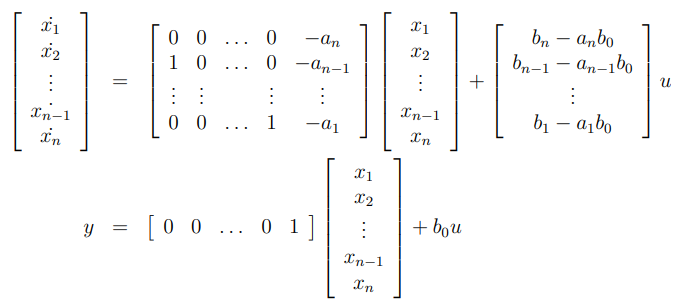

which will allow us to set up a matrix equation that we can solve via least-squares to find the $\alpha_i$. In our case, we will have $b_0 = 0$.

This is a certainly a more convenient form to work with, but is it reasonable to assume that $A$ and $C$ could be in this form? It turns out that, as long as the system is *observable*, we can assume this. We will talk more about this later in the course. 

In this example, instead of using state traces like we have been, we'll be using scalar *output traces*. We'll use the following function to generate output traces from a given system. You don't need to understand the code for this example as the material is out of scope.

In [ ]:
def make_output_trace(a_matrix, b_matrix, c_matrix, inpt, initial_state=None):
    """
    make_output_trace: for a given A, B, and C matrices, initial condition, and input, "run" the system and calculate the system output for each time step. The length of the trace will be the length of the input.
    
    arguments:
        a_matrix: A matrix of the system (numpy matrix, n by n)
        b_matrix: B matrix of the system (numpy matrix, p by n)
        c_matrix: C matrix of the system (numpy matrix, q by n)
        inpt: input (u) (numpy matrix/ndarray, T by p)
        initial_state: initial state for the system (numpy matrix, n by 1)
    
    returns:
        state_trace: a numpy matrix/ndarray containing the state at each time step that was run (numpy ndarray, T by q).
    """
    state_trace = make_state_trace(a_matrix, b_matrix, inpt, initial_state)
    output_trace = state_trace * c_matrix.T
    return output_trace

Due to the special assumption we make about the form of $A$ and $C$, we cannot use the same system identification code from before. To do system identification with outputs, we need a new function that sets up the correct least-squares problem and solves it. The function below does this.

In [ ]:
def identify_system_from_output(output_trace, inpt, n_states):
    """
    identify_system_from_output: given an input to a system and the corresponding output, identify the system that 
    was used to transfer the input to the output. The system is identified as an A matrix in Observable Canonical Form,
    plus a B matrix.
    
    arguments:
        output_trace: the output data.
        inpt: the input data:
        
    returns:
        a_identified: the A matrix identified from the state and input data.
        b_identified: the B matrix identified from the state and input data.
    
    """
    
    # set up least-squares equation from state and input data
    k = np.shape(output_trace)[0]
    assert k > n_states, 'Not enough data for output system ID with the desired number of states.'
    n_inputs = np.shape(inpt)[1]
    
    lsq_a = np.zeros((k-n_states, n_states+n_states*n_inputs))
    for j in range(k-n_states):
        lsq_a[j,:n_states] = output_trace[j:j+n_states].T[0]
        for w in range(n_inputs):
            lsq_a[j,n_states+w*n_inputs:n_states+(w+1)*n_states] = inpt[j:j+n_states,w].T
        
    lsq_b = output_trace[n_states:,:]
    
    alphab_identified, residuals, rank, s = np.linalg.lstsq(lsq_a, lsq_b, rcond=None)
    alpha_identified = alphab_identified[:n_states]
    b_identified = alphab_identified[n_states:].reshape((n_states, n_inputs))
    a_identified = np.zeros((n_states, n_states))
    for j in range(n_states-1):
        a_identified[j+1, j] = 1
        a_identified[j, n_states-1] = alpha_identified[j]
    a_identified[n_states-1, n_states-1] = alpha_identified[n_states-1]
    return a_identified, b_identified

Now that we have those functions, let's try them out. First, we'll need a system.

In [ ]:
n = 4  # number of state variables in the random system
a_known, b_known = make_random_system(n, 1, z_min=0,z_max=0.6)
c_known = np.matrix(np.zeros((1,n)))
c_known[-1]=1  # c_known = [0 0 0 ... 0 1]

Next, we'll generate an output trace, do system identification using the input and output data, and then compare the eigenvalues of the true system and the identified system.

In [ ]:
k = 15
t = t = np.arange(k)
u_trace = random_input(t, 1)
y_trace = make_output_trace(a_known, b_known, c_known, u_trace)

a_identified, b_identified = identify_system_from_output(y_trace, u_trace, n)

plot_eigenvalues([a_known, a_identified], ['true eigenvalues', 'identified eigenvalues'])

Well, how did it do? Keep in mind that, since we only get a scalar data point at each of the $k$ time steps, we might expect that we need a larger $k$ to get a good estimate for $A$ and $B$ than we did when we had full state data. Try running the above cell with a few different values of $k$, and see how many it takes to get a good estimate. Try combining this with adding noise.

Recall that, in order to be able to estimate $A$ and $B$ from scalar output observations, we said that the system had to be *observable*. If the system isn't observable, it can't be done. Now, consider that you just picked a system totally at random, and tried to identify $A$ and $B$. Given the results you've seen, do you think it's rare or common for a system to be observable? (Remember that each time you run the above cells, you are generating random systems.)

## Example 5: Deliberately Undermodeling a System.

In the last example, we saw that we don't necessarily need super-detailed information on the system to accurately identify $A$ and $B$. Perhaps we can use that to our advantage.

If you know that a system has $n$ states, of course the most accurate model of the system will reflect this. However, it may be the case that you have more states than are really necessary to accurately capture the dynamics of your system. In this case, it would be nice if you could discard some states. If you start off with a large amount of state variables (say $n=50$), it might even be necessary.

Here we will explore what happens when we *undermodel* a system. This is when we choose to model some subset of $q<n$ state variables from our state trace, in the hopes that we capture the $q$ most important eigenvalues of the true system.

First, we will create a high-order model, take a state trace, and then take the best subset of the states to use for undermodeling. "Best" here means the states that correspond to the largest eigenvalues, as intuitively the largest eigenvalues contribute the most to the response.

Note that here, we specifically construct a system that has eigenvalues at 0.5 and 0.9, and the rest of the eigenvalues having small magnitude between 0 and 0.05. Also note that we specifically construct the system such that the given eigenvalues correspond to the first two state variables, which was done for simplicity.

In [ ]:
n = 16  # number of state variables in the random system
a_known, b_known = make_random_system(n, 1, z_min=0,z_max=0.05, must_have_real_eigenvalues=[0.5, 0.9]) 
## CHANGE the value in must_have_real_eigenvalues to add other eigenvalues to the system

k = 100
t = t = np.arange(k)

u_trace = random_input(t, 1)
x_trace = make_state_trace(a_known, b_known, u_trace)

a_sys, b_sys = identify_system(x_trace, u_trace)

eval_mag = np.abs(np.linalg.eigvals(a_sys))
sorted_idx = sorted(np.arange(n), key=lambda i: eval_mag[i], reverse=True)
print("State variables with largest eigenvalue magnitude (descending):\n", sorted_idx)

q = 5
um_x_trace = x_trace[:, sorted_idx[:q]]  # take the best q state variables

Now, let's find a model for the best $q=5$ state variables we selected for undermodeling. Remember that the best ones are chosen by choosing the state variables corresponding to the largest eigenvalues, as they will be the ones that most change our system dynamics. We can see that the first state variable at index 0 is always the best due to the way we constructed the system.

In [ ]:
a_um, b_um = identify_system(um_x_trace, u_trace)

Did we capture the major eigenvalues? Let's find out.

In [ ]:
plot_eigenvalues([a_known, a_um], ['true eigenvalues', 'undermodeled eigenvalues'])

Looks like we successfully modeled the eigenvalues, only using 5 states. Try playing around with the number of overall states $n$, number of undermodeled states $q$, and the eigenvalues of the initial system.